In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.io import *
from fastai.conv_learner import *
from fastai.text import *
from fastai.column_data import *

In [2]:
# from fsm import *

In [3]:
DATA_PATH = Path('data')
DATA_PATH
TMP_PATH = DATA_PATH/'tmp'
TMP_PATH.mkdir(exist_ok=True)

In [4]:
sql_ids = np.load(TMP_PATH/'sql_ids.npy')
sql_itos = pickle.load(open(TMP_PATH/'sql_itos.pkl','rb'))
sql_stoi =  collections.defaultdict(lambda: 3, {v:k for k,v in enumerate(sql_itos)})

In [5]:
# fsm = Rule_Parse_FSM()
# get_next_random("select userid from users where ".split())
# get_next_random_fsm("select userid from users where ".split(), fsm)

## Setup

Set up directory path

In [6]:
dataset = pd.read_json(DATA_PATH/'train.json')
dataset.head(1)


,comments,description,id,sql,sql_plain,title,url
0,[],,586912,"SELECT p.Title,p.score,p.ViewCount,p.AnswerCou...","SELECT \np.Title,p.score,p.ViewCount,p.AnswerC...",Repent 151-160,http://data.stackexchange.com/stackoverflow/re...


In [7]:
# get_next_random("select userid from users where ".split())

SQL = dataset.sql
SQL = SQL.str.lower() # Pad space around non character string

In [8]:
SQL = SQL.str.replace('(\W)', r' \1 ')

In [9]:
SQL[:2]

0    select   p . title , p . score , p . viewcount...
1    create   table    # customerdb    (    id   in...
Name: sql, dtype: object

###  Weird Spacy

In [10]:
tmp =["id userid normal ac hed wed theyd  itd ID WED"]

In [11]:
Tokenizer.proc_all(tmp,lang='en') ## Seems confirm Jeremy's Theory

[['i',
  'd',
  'userid',
  'normal',
  'ac',
  'he',
  'd',
  'we',
  'd',
  'they',
  'd',
  'it',
  'd',
  'i',
  'd',
  't_up',
  'we',
  'd']]

## Parallel processing

In [12]:
def lambda_split(x):
    return x.split() 

In [13]:
def proc_all_mp(ss):
        ncpus = num_cpus()//2
        with ProcessPoolExecutor(ncpus) as e:
            return list(e.map(lambda_split, ss))

In [14]:
%time tmp = proc_all_mp(SQL)

CPU times: user 7.25 s, sys: 2.57 s, total: 9.82 s
Wall time: 7.93 s


In [15]:
%time [i.split() for i in SQL]
print("")

CPU times: user 173 ms, sys: 36.1 ms, total: 209 ms
Wall time: 208 ms



In [16]:
%time SQL.apply(lambda x : x.split())
print("")

CPU times: user 134 ms, sys: 40.3 ms, total: 174 ms
Wall time: 173 ms



In [17]:
%time SQL.str.split()
print("")

CPU times: user 160 ms, sys: 18.8 ms, total: 178 ms
Wall time: 178 ms



In [18]:
sql_tok = SQL.str.split()
" ".join(sql_tok[0])

'select p . title , p . score , p . viewcount , p . answercount , p . commentcount , len ( p . body ) as ques_size , p . favoritecount , p . id , u . reputation as user_repo , u . creationdate as user_join_date , datediff ( minute , p . creationdate , a . creationdate ) as qatimegap from posts as p , posts as a , users as u where p . id = a . parentid and p . owneruserid = u . id and a . creationdate = ( select min ( tau . creationdate ) from posts tau where tau . parentid = p . id group by tau . parentid ) and ( p . title like \' % recommended method for handling unsupportedencodingexception from string . getbytes ( " utf - 8 " ) % \' or p . title like \' % way to format strings with " ? " parameters to full string in java ? % \' or p . title like \' % how to parse a string without regular expressions % \' or p . title like \' % how to replace string only once without regex in java ? % \' or p . title like \' % efficiently removing specific characters ( some punctuation ) from strings

Clean up SQL that are too long/short.

In [19]:
lens=[len(i) for i in sql_tok]
lens= np.array(lens)

In [20]:
lens[:10]

array([316, 308,  24, 178,  44,  52,  84,  99, 190,  38])

In [21]:
lens.mean(),lens.min(),lens.max(),lens.std()

(83.80332601447508, 1, 863, 79.63395093587785)

(array([0.66122, 0.8905 , 0.95857, 0.98248, 0.99435, 0.99829, 0.99955, 0.9998 , 0.99992, 1.     ]),
 array([  1. ,  87.2, 173.4, 259.6, 345.8, 432. , 518.2, 604.4, 690.6, 776.8, 863. ]),
 <a list of 10 Patch objects>)

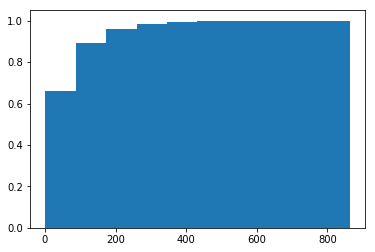

In [22]:
plt.hist(lens,cumulative=True,density=True)

In [23]:
tmp = len(sql_tok)
sql_tok = [i for i in sql_tok if len(i)>=4 and len(i)< int(lens.mean()+ 2*lens.std())] # Roughly 95% data
print('Filter out ', tmp - len(sql_tok), "sentences")

Filter out  1239 sentences


In [24]:
def toks2ids(tok,pre):
    freq = Counter(p for o in tok for p in o)
    itos = [o for o,c in freq.most_common()] ## Avoid rare tokens
    itos.insert(0, '_bos_')
    itos.insert(1, '_pad_')
    itos.insert(2, '_eos_')
    itos.insert(3, '_unk')
    stoi = collections.defaultdict(lambda: 3, {v:k for k,v in enumerate(itos)})
    ids = np.array([([0] + [stoi[o] for o in p] + [2]) for p in tok]) # pad bos at beginning and eos at the end
    np.save(TMP_PATH/f'{pre}_ids.npy', ids)
    pickle.dump(itos, open(TMP_PATH/f'{pre}_itos.pkl', 'wb'))
    return ids,itos,stoi

In [25]:
sql_ids,sql_itos,sql_stoi = toks2ids(sql_tok,'sql')

In [5]:
sql_ids_concat= []
for i in sql_ids:
    sql_ids_concat += i

In [6]:
len(sql_itos)

16288

In [7]:
sql_ids.shape

(23355,)

In [8]:
vocab_size = len(sql_itos)
print('total words:', vocab_size)

total words: 16288


### Create inputs

In [9]:
cs=16


c_in_dat = [[sql_ids_concat[i+j] for i in range(cs)] for j in range(0, len(sql_ids_concat)-cs-1, cs)]
c_out_dat = [[sql_ids_concat[i+j] for i in range(cs)] for j in range(1, len(sql_ids_concat)-cs, cs)]

xs = np.stack(c_in_dat)
ys = np.stack(c_out_dat)

In [10]:
xs.shape,ys.shape

((106545, 16), (106545, 16))

In [11]:
xs[:3]

array([[  0,  12,  11,  13, 103,  19,  90,   6, 104,   7,  35,   8,  22, 497,  22, 123],
       [ 22,   8,  24,  18, 121,   6, 104,   7, 114,   2,   0,  76,  31,  13, 146,   9],
       [140,   6, 146,   5,   8,  14,  14, 237, 125, 194,  39, 330,  39, 100,  14,  14]])

In [12]:
ys[:3]

array([[ 12,  11,  13, 103,  19,  90,   6, 104,   7,  35,   8,  22, 497,  22, 123,  22],
       [  8,  24,  18, 121,   6, 104,   7, 114,   2,   0,  76,  31,  13, 146,   9, 140],
       [  6, 146,   5,   8,  14,  14, 237, 125, 194,  39, 330,  39, 100,  14,  14,   8]])

In [13]:
bs=256

In [14]:
val_idx = get_cv_idxs(len(xs)-cs-1)
md = ColumnarModelData.from_arrays('.', val_idx, xs, ys, bs=bs)

## Model

In [36]:
import pdb

In [15]:
n_hidden=256
n_fac=128
dropout=0.5

In [16]:
class CharSeqStatefulGRU(nn.Module):
    def __init__(self, vocab_size, n_fac, bs):
        super().__init__()
        self.vocab_size = vocab_size
        self.e = nn.Embedding(vocab_size, n_fac)
        self.rnn1 = nn.GRU(n_fac, n_hidden, num_layers=2, dropout=dropout, bidirectional=False)
        self.l_out = nn.Linear(n_hidden, vocab_size)
        self.init_hidden(bs)
        
    def forward(self, *cs):
        bs = cs[0].size(0)
        if self.h1.size(1) != bs: self.init_hidden(bs)
        inp = self.e(torch.stack(cs))
        outp,h1 = self.rnn1(inp, self.h1)
        self.h1 = repackage_var(h1)
        #pdb.set_trace()
        return F.log_softmax(self.l_out(outp), dim=-1)
    
    def init_hidden(self, bs): 
        self.h1 = V(torch.zeros(2, bs, n_hidden))
       

In [17]:
class CharSeqStatefulGRU_Bidir(nn.Module):
    def __init__(self, vocab_size, n_fac, bs):
        super().__init__()
        self.vocab_size = vocab_size
        self.e = nn.Embedding(vocab_size, n_fac)
        self.rnn1 = nn.GRU(n_fac, n_hidden, num_layers=2, dropout=dropout, bidirectional=True)
        self.l_out = nn.Linear(n_hidden*2, vocab_size)
        self.init_hidden(bs)
        
    def forward(self, *cs):
        bs = cs[0].size(0)
        if self.h1.size(1) != bs: self.init_hidden(bs)
        inp = self.e(torch.stack(cs))
        outp,h1 = self.rnn1(inp, self.h1)
        self.h1 = repackage_var(h1)
        #pdb.set_trace()
        return F.log_softmax(self.l_out(outp), dim=-1)
    
    def init_hidden(self, bs): 
        self.h1 = V(torch.zeros(4, bs, n_hidden))
       

In [18]:
def get_next(inp):
    idxs = T(np.array([sql_stoi[c] for c in inp]))
    p = m(*VV(idxs))
    p = to_np(p)[0]
    i = np.argmax(p[-1,:,:])
    
    return sql_itos[i]

def get_next_random(inp, n):
    idxs = T(np.array([sql_stoi[c] for c in inp]))
    p = m(*VV(idxs))
    p = to_np(p[-1,:,:])[0]
    pi = p.argsort()[-n:] # Sample the 10 most possible token only
    i = np.random.choice(pi, p=softmax_np(p[pi]))
    return sql_itos[i]

def softmax_np (nparray):
    ans = np.exp(nparray)
    return ans/ans.sum()


def get_sentence(inp):
    sentence = inp
    counter = 0
    tmp = []
    while "_eos_" not in tmp:   
        tmp = get_next(sentence[-cs:]) 
        sentence += [tmp]
        counter = counter+1
        if counter> 200:
            break
    return sentence

def get_sentence_random(inp, n):
    sentence = inp
    counter = 0
    tmp = []
    while "_eos_" not in tmp:   
        tmp = get_next_random(sentence[-cs:], n) 
        sentence += [tmp]
        counter = counter+1
        if counter> 100:
            break
    return sentence

In [19]:
def test_case():
    sample = ['update','select','delete','insert']
    
#     for i in sample:
#         print('Input:', i, 'output:', i + " " + get_next(i))       
#     for i in sample:
#         print('Input:', i, 'output:', " ".join(get_sentence([i])))    
        
    print('For Random Generation, sample 10 most possible tokens')
    
                    
    for i in sample:
        print('Input:', i, 'output:', " ".join(get_sentence_random([i], 10)))  
        print()
        
    print('Sample 5 most possible tokens')
                    
    for i in sample:
        print('Input:', i, 'output:', " ".join(get_sentence_random([i], 5)))  
        print()

In [20]:
def nll_loss_seq(inp, targ):
    sl,bs,nh = inp.size()
    targ = targ.transpose(0,1).contiguous().view(-1)
    targ = targ.view(-1)
    return F.nll_loss(inp.view(-1,nh), targ)

In [43]:
print('n_hidden:',n_hidden,'n_fac:',n_fac,'dropout:',dropout)
            
m = CharSeqStatefulGRU_Bidir(len(sql_itos), n_fac, bs=bs)
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))
learn = RNN_Learner(md, SingleModel(to_gpu(m)), opt_fn=opt_fn)
learn.crit = nll_loss_seq

n_hidden: 256 n_fac: 128 dropout: 0.5


In [21]:
def accuracy(preds, targs):
    preds = torch.max(preds.view(-1,len(sql_itos)), dim=1)[1]
    targs = targs.transpose(0,1).contiguous().view(-1)
    return (preds==targs).float().mean()

In [45]:
learn.metrics = [accuracy]

In [46]:
learn.fit(1e-2, 1, cycle_len=5,use_clr_beta = (5,10,0.95,0.85))

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.524841   0.430644   0.937227  
    1      0.442224   0.444568   0.939864                    
    2      0.43317    0.454402   0.94437                     
    3      0.319061   0.401509   0.949789                    
    4      0.251494   0.368262   0.952705                    



[array([0.36826]), 0.9527047644672022]

In [47]:
learn.save('model_bidir')

In [63]:
test_case()

For Random Generation, sample 10 most possible tokens
Input: update output: update toptenusers store store be be update jumps store store toptenusers toptenusers search_type_id toptenusers update toptenusers store toptenusers top10reptotal store store be larger than 181965 store store toptenusers toptenusers cologne toptenusers toptenusers toptenusers be values 15 when posttime be larger than float declare @ toptenusers toptenusers cologne ) person_id decimal ( 15 15 when 90 subcatgroup open than float declare @ toptenusers toptenusers values ( person_id decimal ( 15 15 when 90 subcatgroup open than float declare @ toptenusers toptenusers values ( person_id decimal ( 15 15 when 90 subcatgroup open than float declare @ toptenusers toptenusers values ( person_id decimal (

Input: select output: select 15 select count ( select distinct 1 select count * * ) select distinct pt . postid as [ post link ] , 1 select count ( * ) from posttags pt . postid as [ post link ] , p . count ( * ) from 

## Without Bidirectional

In [22]:
m = CharSeqStatefulGRU(len(sql_itos), n_fac, bs=bs)
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))
learn = RNN_Learner(md, SingleModel(to_gpu(m)), opt_fn=opt_fn)
learn.crit = nll_loss_seq

In [65]:
learn.metrics =[accuracy]

In [66]:
learn.fit(1e-2, 1, cycle_len=5,use_clr_beta = (5,10,0.95,0.85))

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                   
    0      4.151299   4.041293   0.252928  
    1      3.643026   3.583236   0.336171                   
    2      2.462626   2.295749   0.53197                    
    3      2.187626   2.114319   0.558994                   
    4      2.035453   2.025491   0.571048                   



[array([2.02549]), 0.5710484629784132]

In [67]:
learn.save('model_singledir')

In [23]:
learn.load('model_singledir')

In [38]:
get_next_random(['_eos_'],5)

'_bos_'

In [39]:
test_case()

For Random Generation, sample 10 most possible tokens
Input: update output: update null order by p . creationdate desc _eos_

Input: select output: select count ( postid ) as num , tags from posts where owneruserid = @ userid _eos_

Input: delete output: delete ' order by reputation desc ; _eos_

Input: insert output: insert into # customer , @ top10reptotal int , up int , down int set @ enddate = 1 and posts . communityowneddate is null and p . closeddate is null and p . answercount = 0 and p . score ) < 200 and p . creationdate > = dateadd ( month , 0 ) order by reputation desc ) as [ # ] , id as [ user link ] , reputation from users where lower ( location ) like ' % india % ' or upper ( location select ' http : / / stackoverflow . com / questions

Sample 5 most possible tokens
Input: update output: update ? 1 # # ; with cte as ( select count ( * ) from votes v inner join posts a on q . id = q . owneruserid where lower ( location ) like ' % india ' or upper ( location ) like ' % sg '

In [71]:
learn.fit(1e-3, 1, cycle_len=3,use_clr_beta = (5,10,0.95,0.85))

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                   
    0      2.016179   2.012666   0.572656  
    1      1.983365   1.992622   0.576059                   
    2      1.955467   1.982495   0.577872                   



[array([1.98249]), 0.5778719783724543]

In [72]:
learn.save('model_singledir_2')

In [73]:
test_case()

For Random Generation, sample 10 most possible tokens
Input: update output: update # # and q . acceptedanswerid = q . id and v . votetypeid = 3 group by tagname order by score asc _eos_

Input: select output: select p . viewcount as float ) / cast ( score + ( upvotes / datediff ( minute , creationdate , getdate ( ) ) as ' # # userid # # and p . tags like ' % < code > = ' android ' ) group by t . tagname order by count ( * ) desc ; _eos_

Input: delete output: delete ' _eos_

Input: insert output: insert into @ products values ( 2 , 3 , 2 ) and score > = 0 and p . closeddate is null group by year ( p . creationdate ) , month ( p . creationdate ) , p . creationdate , 112 ) from comments c where p . closeddate is null and closeddate is null order by score asc _eos_

Sample 5 most possible tokens
Input: update output: update # # select * from posts where posttypeid = 2 and communityowneddate is null order by reputation desc _eos_

Input: select output: select top 10 * from comments where u

In [108]:
get_next(['from'])

NotImplementedError: <U4

# Borrow Jason's Pre-processing https://gist.github.com/jasonjmcghee/bf65447cdb55280e0c942441218e226a and plug into my model

In [74]:
DATA = Path('data')
SENLIDB = DATA_PATH

with open(SENLIDB/'train.json') as data_file:    
    senlidb_train = json.load(data_file)
    
# with open(SENLIDB/'test.json') as data_file:    
#     senlidb_test = json.load(data_file)

def buildDataFrames(senlidb):
    sqls, titles, descriptions = zip(*[(o["sql"], o["title"], o["description"]) for i,o in enumerate(senlidb)])
    return pd.DataFrame({"sql": sqls, "title": titles, "description": descriptions}, columns={"title", "description", "sql"})

df_trn = buildDataFrames(senlidb_train)
# df_test = buildDataFrames(senlidb_test)

TMP_PATH = DATA/'tmp'
TMP_PATH.mkdir(exist_ok=True)

df_trn.to_csv(str(TMP_PATH/'train.csv'), index=False)
# df_test.to_csv(str(TMP_PATH/'test.csv'), index=False)

df_trn = pd.read_csv(str(TMP_PATH/'train.csv')).fillna('')
# df_test = pd.read_csv(str(TMP_PATH/'test.csv')).fillna('')

In [75]:
df_trn.shape

df_lm = pd.concat([df_trn], axis=0)

trn_texts, val_texts = sklearn.model_selection.train_test_split(df_lm, test_size=0.1)

In [76]:
sql_keywords = ['ADD', 'EXTERNAL', 'PROCEDURE', 'ALL', 'FETCH', 'PUBLIC', 'ALTER', 'FILE', 'RAISERROR', 'AND', 'FILLFACTOR', 'READ', 'ANY', 'FOR', 'READTEXT', 'AS', 'FOREIGN', 'RECONFIGURE', 'ASC', 'FREETEXT', 'REFERENCES', 'AUTHORIZATION', 'FREETEXTTABLE', 'REPLICATION', 'BACKUP', 'FROM', 'RESTORE', 'BEGIN', 'FULL', 'RESTRICT', 'BETWEEN', 'FUNCTION', 'RETURN', 'BREAK', 'GOTO', 'REVERT', 'BROWSE', 'GRANT', 'REVOKE', 'BULK', 'GROUP', 'RIGHT', 'BY', 'HAVING', 'ROLLBACK', 'CASCADE', 'HOLDLOCK', 'ROWCOUNT', 'CASE', 'IDENTITY', 'ROWGUIDCOL', 'CHECK', 'IDENTITY', 'INSERT', 'RULE', 'CHECKPOINT', 'IDENTITYCOL', 'SAVE', 'CLOSE', 'IF', 'SCHEMA', 'CLUSTERED', 'IN', 'SECURITYAUDIT', 'COALESCE', 'INDEX', 'SELECT', 'COLLATE', 'INNER', 'SEMANTICKEYPHRASETABLE', 'COLUMN', 'INSERT', 'SEMANTICSIMILARITYDETAILSTABLE', 'COMMIT', 'INTERSECT', 'SEMANTICSIMILARITYTABLE', 'COMPUTE', 'INTO', 'SESSION', 'USER', 'CONSTRAINT', 'IS', 'SET', 'CONTAINS', 'JOIN', 'SETUSER', 'CONTAINSTABLE', 'KEY', 'SHUTDOWN', 'CONTINUE', 'KILL', 'SOME', 'CONVERT', 'LEFT', 'STATISTICS', 'CREATE', 'LIKE', 'SYSTEM', 'USER', 'CROSS', 'LINENO', 'TABLE', 'CURRENT', 'LOAD', 'TABLESAMPLE', 'CURRENT', 'DATE', 'MERGE', 'TEXTSIZE', 'CURRENT', 'TIME', 'NATIONAL', 'THEN', 'CURRENT', 'TIMESTAMP', 'NOCHECK', 'TO', 'CURRENT', 'USER', 'NONCLUSTERED', 'TOP', 'CURSOR', 'NOT', 'TRAN', 'DATABASE', 'NULL', 'TRANSACTION', 'DBCC', 'NULLIF', 'TRIGGER', 'DEALLOCATE', 'OF', 'TRUNCATE', 'DECLARE', 'OFF', 'TRY', 'CONVERT', 'DEFAULT', 'OFFSETS', 'TSEQUAL', 'DELETE', 'ON', 'UNION', 'DENY', 'OPEN', 'UNIQUE', 'DESC', 'OPENDATASOURCE', 'UNPIVOT', 'DISK', 'OPENQUERY', 'UPDATE', 'DISTINCT', 'OPENROWSET', 'UPDATETEXT', 'DISTRIBUTED', 'OPENXML', 'USE', 'DOUBLE', 'OPTION', 'USER', 'DROP', 'OR', 'VALUES', 'DUMP', 'ORDER', 'VARYING', 'ELSE', 'OUTER', 'VIEW', 'END', 'OVER', 'WAITFOR', 'ERRLVL', 'PERCENT', 'WHEN', 'ESCAPE', 'PIVOT', 'WHERE', 'EXCEPT', 'PLAN', 'WHILE', 'EXEC', 'PRECISION', 'WITH', 'EXECUTE', 'PRIMARY', 'WITHIN', 'GROUP', 'EXISTS', 'PRINT', 'WRITETEXT', 'EXIT', 'PROC']

functions = ["ASCII", "CHAR", "CHARINDEX", "CONCAT", "DATALENGTH", "LEFT", "LEN", "LOWER", "LTRIM", "NCHAR", "PATINDEX", "REPLACE", "RIGHT", "RTRIM", "SPACE", "STR", "STUFF", "SUBSTRING", "UPPER", "ABS", "AVG", "CEILING", "COUNT", "FLOOR", "MAX", "MIN", "RAND", "ROUND", "SIGN", "SUM", "CURRENT_TIMESTAMP", "DATEADD", "DATEDIFF", "DATENAME", "DATEPART", "DAY", "GETDATE", "GETUTCDATE", "MONTH", "YEAR", "CAST", "CONVERT", "COALESCE", "CURRENT_USER", "ISDATE", "ISNULL", "ISNUMERIC", "NULLIF", "SESSION_USER", "SESSIONPROPERTY", "SYSTEM_USER", "USER_NAME", "CAST"]
functions_lower = [f.lower() for f in functions]

sql_keywords_lower = [keyword.lower() for keyword in sql_keywords]

symbols = ",()='\";{}*!^&+-<>:~`|?"

BOS = 'xbos'  # beginning-of-statement
EOS = 'xeos'  # end-of-statement
SCHEMA = 'xschema'
LITERAL = 'xliteral'

vocab = sql_keywords_lower + list(symbols) + functions_lower + [SCHEMA, LITERAL]

In [77]:
def get_sql_and_fix(df, i):
    sql = df.at[df.index[i],'sql']
    if not isinstance(sql, str):
        sql = ' ; '.join(sql)
    sql_stripped = sql.lower().strip()
    sql_symbols = sql_stripped
    
    # Put spaces around symbols
    for symbol in symbols:
        sql_symbols = f" {symbol} ".join(re.split(f"\{symbol}|\{symbol} | \{symbol}| \{symbol} ", sql_symbols))

    # Swap out blocks like [Foo Bar] for xschema
    sql_symbols = re.sub("\[[^\[\]]*\]", SCHEMA, sql_symbols)

    sql_split = [x for x in sql_symbols.split(" ")  if len(x)]
    if len(sql_split) > 1:
        for i, word in enumerate(sql_split):
            is_number = re.match(r"\d+", word)
            is_literal = re.match(r"^('|\")", word)
            if word not in vocab and not is_number and not is_literal:
                sql_split[i] = SCHEMA
            elif is_number or is_literal:
                sql_split[i] = LITERAL
    return " ".join(sql_split)

In [78]:
def get_texts(df, n_lbls=2):
    labels = df.iloc[:,range(n_lbls)].values
    texts = [f'{BOS} ' + get_sql_and_fix(df, i) + f' ; {EOS}' for i in range(1, df.shape[0])]

    tok = Tokenizer().proc_all_mp(partition_by_cores(texts))
    return tok, list(labels)

trn_texts.at[trn_texts.index[102], 'sql']

get_sql_and_fix(trn_texts, 102)

trn_texts.index[0]

8167

In [79]:
(SENLIDB/'tmp').mkdir(exist_ok=True)

trn_tok, trn_labels = get_texts(trn_texts, 2)

test_tok, test_labels = get_texts(val_texts, 2)

np.save(SENLIDB/'tmp'/'tok_trn.npy', trn_tok)
np.save(SENLIDB/'tmp'/'tok_val.npy', test_tok)

In [80]:
tok_trn = np.load(SENLIDB/'tmp'/'tok_trn.npy')
tok_test = np.load(SENLIDB/'tmp'/'tok_val.npy')

freq = Counter(p for o in tok_trn for p in o if p in vocab)
freq.most_common(25)

itos = [o for o,c in freq.most_common(len(vocab)) if o in vocab]
itos.insert(0, '_pad_')
itos.insert(0, '_unk_')

stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

191

In [81]:
trn_lm = np.array([[stoi[o] for o in p] for p in tok_trn])

val_lm = np.array([[stoi[o] for o in p] for p in tok_test])

trn_lm.shape

val_lm.shape

np.save(SENLIDB/'tmp'/'trn_ids.npy', trn_lm)
np.save(SENLIDB/'tmp'/'val_ids.npy', val_lm)
pickle.dump(itos, open(SENLIDB/'tmp'/'itos.pkl', 'wb'))

## Run this directly if you have run the previous cell at least once before

In [82]:
trn_lm = np.load(SENLIDB/'tmp'/'trn_ids.npy')
val_lm = np.load(SENLIDB/'tmp'/'val_ids.npy')
itos = pickle.load(open(SENLIDB/'tmp'/'itos.pkl', 'rb'))

vs=len(itos)
vs,len(trn_lm)

(191, 22133)

In [83]:
def generate_sql(start="xbos select"):
    tok = Tokenizer()
    s = [tok.spacy_tok(start)]
    tok_arr = np.array([[stoi[o] for o in p] for p in s])
    output = start.split(" ")[1].upper()
    while True:
        tok_idx = get_next(tok_arr)
        word = itos[tok_idx]
        if word in sql_keywords_lower:
            word = word.upper()
        output += " " + word
        tok_arr = np.reshape(np.append(tok_arr[0][1:],[tok_idx]),(1,2))
        if word == ";": break
    return output

def get_next(token):
    probs = learn.model(*VV(token))
    return to_np(torch.multinomial(probs[0][-1].exp(), 1))[0]

In [84]:
sql_ids_concat = np.concatenate(trn_lm) # Hook to match Jason code
sql_itos = itos
sql_stoi = stoi

In [85]:
bs=256

In [86]:
cs=16
c_in_dat = [[sql_ids_concat[i+j] for i in range(cs)] for j in range(0, len(sql_ids_concat)-cs-1, cs)]
c_out_dat = [[sql_ids_concat[i+j] for i in range(cs)] for j in range(1, len(sql_ids_concat)-cs, cs)]

xs = np.stack(c_in_dat)
ys = np.stack(c_out_dat)

In [87]:
val_idx = get_cv_idxs(len(xs)-cs-1)
md = ColumnarModelData.from_arrays('.', val_idx, xs, ys, bs=bs)

In [88]:
n_hidden= 256
n_fac=64
dropout=0.5
bidir=False

In [89]:
print('n_hidden:',n_hidden,'n_fac:',n_fac,'bidir:',bidir,'dropout:',dropout)
            
m = CharSeqStatefulGRU(len(sql_itos), n_fac, bs=bs)
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))
learn = RNN_Learner(md, SingleModel(to_gpu(m)), opt_fn=opt_fn)
learn.crit = nll_loss_seq
learn.metrics = [accuracy]
learn.fit(1e-2, 1, cycle_len=5,use_clr_beta = (5,10,0.95,0.85))

n_hidden: 256 n_fac: 64 bidir: False dropout: 0.5


HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                   
    0      1.242543   1.174477   0.666363  
    1      1.177888   1.152642   0.668173                   
    2      1.172578   1.122859   0.675143                   
    3      1.128307   1.091885   0.681611                   
    4      1.094723   1.063962   0.687846                   



[array([1.06396]), 0.6878460207263428]

In [90]:
for i in range(5):
    print(generate_sql("xbox select"))
    print()

for i in range(5):
    print(generate_sql("xbos update"))
    print()

for i in range(10):
    cmd = random.choice(["select", "update", "insert", "delete"])
    print(generate_sql(f"xbos {cmd}"))
    print()

SELECT dateadd ( day , datediff ( day , xliteral , xschema ) , xliteral ) - xliteral ) * xliteral + xschema - xschema ) + xschema AS xschema FROM xschema xschema LEFT JOIN xschema xschema ON xschema = xschema WHERE xschema IN ( xliteral , xliteral ) AND xschema = xschema FETCH xschema FROM xschema xschema WHERE xschema LIKE xliteral xschema < xliteral + xschema END AS xschema , count ( xschema ) AS xschema FROM xschema GROUP BY xschema , xschema ORDER BY xliteral AS xschema FROM xschema GROUP BY xschema ORDER BY count DESC ;

SELECT xschema , sum ( CASE WHEN xschema = xliteral THEN xliteral ELSE xliteral END ) , count ( * ) FROM xschema ) ) = xliteral ORDER BY sum ( xschema ) DESC ;

SELECT TOP xliteral xschema , xschema , xschema : xliteral + cast ( xschema AS xschema ) ) + xliteral xschema xliteral AS xschema FROM xschema AS xschema LEFT JOIN ( SELECT xschema , xschema AS xschema , xschema ORDER BY xschema DESC , COALESCE ( xschema , xschema ) AS xschema FROM xschema xschema JOIN xsc